In [1]:
%cd /mnt/i/Yuki/workspace/exercises/image_processing_100_knock/Gasyori100knock

/mnt/i/Yuki/workspace/exercises/image_processing_100_knock/Gasyori100knock


https://github.com/yoyoyo-yo/Gasyori100knock/tree/master/Question_91_100

# 準備

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
imori_img_path = 'Question_91_100/imori.jpg'
imori_img = cv2.imread(imori_img_path)
imori_img2_path = 'Question_91_100/imori_1.jpg'
imori_img2 = cv2.imread(imori_img2_path)
imori_many_path = 'Question_91_100/imori_many.jpg'
imori_many = cv2.imread(imori_many_path)
madara_img_path = 'Question_91_100/madara.jpg'
madara_img = cv2.imread(madara_img_path)

## OpenCV は BGR を採用しているので RGB に変換する
BGR を採用している理由は単なる歴史的経緯らしい

In [4]:
imori_img = imori_img[:, :, ::-1]
imori_img2 = imori_img2[:, :, ::-1]
imori_many = imori_many[:, :, ::-1]
madara_img = madara_img[:, :, ::-1]

# Utility Function

In [5]:
def get_gray_scale(img):
    return img[:, :, 0] * 0.2126 + img[:, :, 1] * 0.7152 + img[:, :, 2] * 0.0722

In [6]:
def bi_linear(img, a):
    base = img.copy()
    ans = np.zeros((int(base.shape[0] * a), int(base.shape[1] * a), 3))
    for i in range(ans.shape[0]):
        for j in range(ans.shape[1]):
            base_i = int(np.floor(i / a))
            base_j = int(np.floor(j / a))

            for i0 in range(2):
                for j0 in range(2):
                    di = abs(1 - (i / a - base_i) - i0)
                    dj = abs(1 - (j / a - base_j) - j0)
                    target_i = max(min(base_i + i0, base.shape[0] - 1), 0)
                    target_j = max(min(base_j + j0, base.shape[1] - 1), 0)
                    ans[i, j] += di * dj * base[target_i, target_j]

    ans = ans.astype(np.uint8)
    
    return ans

In [7]:
def get_hog(img):
    def grad(img):
        base = img.copy().astype(np.float)
        lum = base[:, :, 0] * 0.2126 + base[:, :, 1] * 0.7152 + base[:, :, 2] * 0.0722

        lum = np.pad(lum, (1, 1), 'edge')
        gx = lum[1:-1, 2:] - lum[1:-1, :-2]
        gy = lum[2:, 1:-1] - lum[:-2, 1:-1]

        mag = np.sqrt(gx ** 2 + gy ** 2)
        gx[np.abs(gx) < 1e-10] = 1e-10
        ang = np.arctan(gy / gx)
        q_ang = ((ang * 180 / np.pi) % 180) // 20
        q_ang = q_ang.astype(np.uint8)
        
        return mag, q_ang
    
    def histogram(mag, q_ang):
        N = 8
        h = (q_ang.shape[0] + N - 1) // N
        w = (q_ang.shape[1] + N - 1) // N

        cells = np.zeros((h, w, 9))

        for i in range(q_ang.shape[0]):
            for j in range(q_ang.shape[1]):
                i_cell = i // N
                j_cell = j // N
                cells[i_cell, j_cell, q_ang[i, j]] += mag[i, j]
        
        return cells
    
    def normalize(cells):
        orig = cells.copy()
        normalized = orig.copy()

        C = 3
        epsilon = 1

        orig = np.pad(orig, (C // 2, C // 2), 'constant')

        for i in range(normalized.shape[0]):
            for j in range(normalized.shape[1]):
                normalized[i, j] /= np.sqrt(np.sum(orig[i:i+C, j:j+C] ** 2) + epsilon)
        
        return normalized

    mag, q_ang = grad(img)
    cells = histogram(mag, q_ang)
    normalized = normalize(cells)
    
    return normalized

# 問題

## Q.91. K-meansによる減色処理 (Step.1) 色の距離によるクラス分類

In [8]:
np.random.seed(0)
K = 5

colors = imori_img.copy().reshape((-1, 3)).astype(np.float32)
means = colors[np.random.choice(np.arange(colors.shape[0]), K, replace=True)].copy()

labels = np.argmin(np.sum((np.expand_dims(means, 1) - colors) ** 2, axis=-1), axis=0)

for i in range(K):
    if np.any(labels == i):
        colors[labels == i] = means[i]

colors = colors.reshape(imori_img.shape)
colors = np.clip(colors, 0, 255).astype(np.uint8)

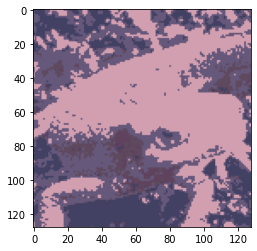

In [9]:
plt.imshow(colors)

## Q.92. K-meansによる減色処理 (Step.2) 減色処理

In [10]:
def reduce_color(img, K):
    np.random.seed(0)

    colors = img.copy().reshape((-1, 3)).astype(np.float32)
    means = colors[np.random.choice(np.arange(colors.shape[0]), K, replace=True)].copy()
    
    count = 0
    prev_labels = None
    while count < 1000:
        count += 1
        print(f'Try {count}')

        labels = np.argmin(np.sum((np.expand_dims(means, 1) - colors) ** 2, axis=-1), axis=0)
        if prev_labels is not None and np.all(prev_labels == labels):
            break

        for i in range(K):
            if np.any(labels == i):
                means[i] = np.mean(colors[labels == i], axis=0)
        prev_labels = labels.copy()

    for i in range(K):
        if np.any(labels == i):
            colors[labels == i] = means[i]

    colors = colors.reshape(imori_img.shape)
    colors = np.clip(colors, 0, 255).astype(np.uint8)
    
    return colors

In [11]:
imori_5 = reduce_color(imori_img, 5)
imori_10 = reduce_color(imori_img, 10)
madara_5 = reduce_color(madara_img, 5)

Try 1
Try 2
Try 3
Try 4
Try 5
Try 6
Try 7
Try 8
Try 9
Try 10
Try 11
Try 12
Try 13
Try 14
Try 15
Try 16
Try 17
Try 18
Try 19
Try 20
Try 21
Try 22
Try 23
Try 24
Try 25
Try 26
Try 27
Try 28
Try 29
Try 30
Try 31
Try 32
Try 33
Try 34
Try 35
Try 36
Try 37
Try 38
Try 39
Try 40
Try 41
Try 42
Try 43
Try 44
Try 45
Try 46
Try 47
Try 48
Try 1
Try 2
Try 3
Try 4
Try 5
Try 6
Try 7
Try 8
Try 9
Try 10
Try 11
Try 12
Try 13
Try 14
Try 15
Try 16
Try 17
Try 18
Try 19
Try 20
Try 21
Try 22
Try 23
Try 24
Try 25
Try 26
Try 27
Try 28
Try 29
Try 30
Try 31
Try 32
Try 33
Try 34
Try 35
Try 36
Try 37
Try 38
Try 39
Try 40
Try 41
Try 42
Try 43
Try 44
Try 45
Try 46
Try 47
Try 48
Try 49
Try 50
Try 51
Try 52
Try 53
Try 54
Try 55
Try 56
Try 57
Try 58
Try 59
Try 60
Try 61
Try 62
Try 63
Try 64
Try 65
Try 66
Try 67
Try 68
Try 69
Try 70
Try 71
Try 72
Try 73
Try 74
Try 75
Try 76
Try 77
Try 78
Try 79
Try 80
Try 81
Try 82
Try 83
Try 84
Try 85
Try 86
Try 87
Try 88
Try 89
Try 90
Try 91
Try 92
Try 93
Try 94
Try 95
Try 96
Try 97
Try

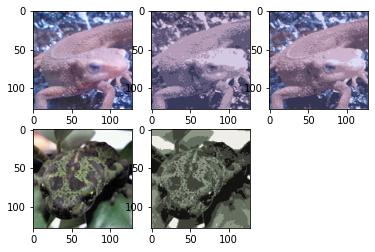

In [12]:
plt.subplot(2, 3, 1)
plt.imshow(imori_img)
plt.subplot(2, 3, 2)
plt.imshow(imori_5)
plt.subplot(2, 3, 3)
plt.imshow(imori_10)
plt.subplot(2, 3, 4)
plt.imshow(madara_img)
plt.subplot(2, 3, 5)
plt.imshow(madara_5)

## Q.93. 機械学習の学習データの用意 (Step.1) IoUの計算

In [13]:
def get_area(a):
    return max(a[2] - a[0], 0) * max(a[3] - a[1], 0)

def get_iou(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])
    intersection_area = np.array([x1, y1, x2, y2])
    
    return get_area(intersection_area) / (get_area(a) + get_area(b) - get_area(intersection_area))

In [14]:
a = np.array((50, 50, 150, 150), dtype=np.float32)
b = np.array((60, 60, 170, 160), dtype=np.float32)

iou = get_iou(a, b)

print(iou)

0.627907


## Q.94. 機械学習の学習データの用意 (Step.2) ランダムクラッピング

In [15]:
np.random.seed(0)
N = 200

img = imori_img2.copy()
H, W, C = img.shape
gt = np.array([47, 41, 129, 103])
crop_h = 60
crop_w = 60
data_h = 32
data_w = 32

data = np.zeros((N, 32, 32, C), dtype=np.uint8)
labels = np.zeros((N,), dtype=np.int)
rects = np.zeros((N, 4), dtype=np.int)
for i in range(N):
    x1 = np.random.randint(W - crop_w)
    y1 = np.random.randint(H - crop_h)
    rect = np.array([x1, y1, x1 + crop_w, y1 + crop_h])
    iou = get_iou(rect, gt)
    
    data[i] = bi_linear(img[y1:y1+crop_h, x1:x1+crop_w], data_h / crop_h)
    labels[i] = 1 if iou >= 0.5 else 0
    rects[i] = rect

In [16]:
result = imori_img2.copy()
for rect, label in zip(rects, labels):
    x1, y1, x2, y2 = rect
    color = [255, 0, 0] if label == 1 else [0, 0, 255]
    result[y1, x1:x2] = color
    result[y2, x1:x2] = color
    result[y1:y2, x1] = color
    result[y1:y2, x2] = color

x1, y1, x2, y2 = gt
color = [0, 255, 0]
result[y1, x1:x2] = color
result[y2, x1:x2] = color
result[y1:y2, x1] = color
result[y1:y2, x2] = color

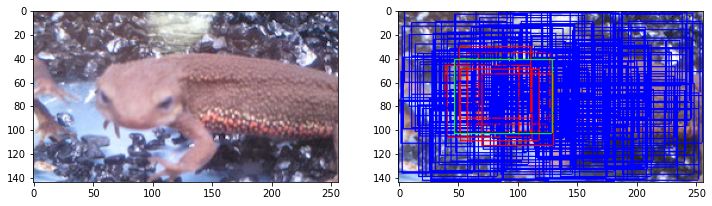

In [17]:
fig = plt.figure(figsize=(12, 60))
plt.subplot(1, 2, 1)
plt.imshow(imori_img2)
plt.subplot(1, 2, 2)
plt.imshow(result)

## Q.95. ニューラルネットワーク (Step.1) ディープラーニングにする

In [18]:
class NN:
    def __init__(self, ind=2, w1=64, w2=64, outd=1, lr=0.1):
        self.w1 = np.random.normal(0, 1, [ind, w1])
        self.b1 = np.random.normal(0, 1, [w1])
        self.w2 = np.random.normal(0, 1, [w1, w2])
        self.b2 = np.random.normal(0, 1, [w2])
        self.wout = np.random.normal(0, 1, [w2, outd])
        self.bout = np.random.normal(0, 1, [outd])
        self.lr = lr

    def forward(self, x):
        self.z1 = x
        self.z2 = sigmoid(np.dot(self.z1, self.w1) + self.b1)
        self.z3 = sigmoid(np.dot(self.z2, self.w2) + self.b2)
        self.out = sigmoid(np.dot(self.z3, self.wout) + self.bout)
        return self.out

    def train(self, x, t):
        # backpropagation output layer
        # Attention: the loss function is not a cross entropy loss but a mean squared error.
        #En = t * np.log(self.out) + (1-t) * np.log(1-self.out)
        En = (self.out - t) * self.out * (1 - self.out)
        grad_En = En #np.array([En for _ in range(t.shape[0])])
        grad_wout = np.dot(self.z3.T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.wout -= self.lr * grad_wout#np.expand_dims(grad_wout, axis=-1)
        self.bout -= self.lr * grad_bout

        # backpropagation inter layer
        grad_u2 = np.dot(En, self.wout.T) * self.z3 * (1 - self.z3)
        grad_w2 = np.dot(self.z2.T, grad_u2)
        grad_b2 = np.dot(np.ones([grad_u2.shape[0]]), grad_u2)
        self.w2 -= self.lr * grad_w2
        self.b2 -= self.lr * grad_b2

        grad_u1 = np.dot(grad_u2, self.w2.T) * self.z2 * (1 - self.z2)
        grad_w1 = np.dot(self.z1.T, grad_u1)
        grad_b1 = np.dot(np.ones([grad_u1.shape[0]]), grad_u1)
        self.w1 -= self.lr * grad_w1
        self.b1 -= self.lr * grad_b1

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [19]:
np.random.seed(0)

lr = 0.1
epoch = 1000

train_x = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
train_t = np.array([[0], [1], [1], [0]], dtype=np.float32)

nn = NN(ind=train_x.shape[1], w1=64, w2=64, outd=1, lr=lr)

# train
for i in range(epoch):
    nn.forward(train_x)
    nn.train(train_x, train_t)

# test
for j in range(train_x.shape[0]):
    x = train_x[j]
    t = train_t[j]
    print("in:", x, "pred:", nn.forward(x))

in: [0. 0.] pred: [0.05879539]
in: [0. 1.] pred: [0.93296943]
in: [1. 0.] pred: [0.94056279]
in: [1. 1.] pred: [0.06710346]


## Q.96. ニューラルネットワーク (Step.2) 学習

In [20]:
np.random.seed(0)

lr = 0.01
epoch = 50000

train_x = np.array([get_hog(datum) for datum in data]).reshape(data.shape[0], -1)
train_t = labels.copy().reshape((-1, 1))

nn = NN(ind=train_x.shape[1], w1=64, w2=64, outd=1, lr=lr)

# train
for i in range(epoch):
    nn.forward(train_x)
    nn.train(train_x, train_t)

In [21]:
# test
threshold = 0.5
hit_count = 0
for j in range(train_x.shape[0]):
    x = train_x[j]
    t = train_t[j][0]
    pred = 1 if nn.forward(x)[0] >= threshold else 0
    hit_count += 1 if t == pred else 0

print(f'Accuracy >> {hit_count / train_x.shape[0]} ({hit_count}/{train_x.shape[0]})')

Accuracy >> 1.0 (200/200)


## Q.97. 簡単な物体検出 (Step.1) スライディングウィンドウ + HOG

In [22]:
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.int)

img = imori_many.copy()
H, W = img.shape[:2]
size = (32, 32)

test_x = []
rects = []
for rec in recs:
    crop_w, crop_h = rec
    for y2 in range(4, H, 4):
        for x2 in range(4, W, 4):
            x1 = max(x2 - crop_w, 0)
            y1 = max(y2 - crop_h, 0)
            
            test_x.append(get_hog(cv2.resize(img[y1:y2, x1:x2], size)))
            rects.append([x1, y1, x2, y2])

test_x = np.array(test_x).reshape((len(test_x), -1))
rects = np.array(rects)

## Q.98. 簡単な物体検出 (Step.2) スライディングウィンドウ + NN

In [23]:
threshold = 0.7
face_infos = []
for x, rect in zip(test_x, rects):
    score = nn.forward(x)[0]
    if score >= threshold:
        face_infos.append(rect.tolist() + [score])

face_infos

[[78, 42, 120, 84, 0.8853802506139175],
 [82, 42, 124, 84, 0.7887669170479743],
 [78, 46, 120, 88, 0.7779566391109591],
 [0, 62, 12, 104, 0.8543362272876218],
 [0, 62, 16, 104, 0.8563447500759782],
 [0, 62, 20, 104, 0.802332089740673],
 [0, 62, 24, 104, 0.9118459663844838],
 [0, 66, 8, 108, 0.9309284705036381],
 [0, 66, 12, 108, 0.9968462172560072],
 [0, 66, 16, 108, 0.9593827396585138],
 [0, 66, 20, 108, 0.8745418636344693],
 [0, 70, 12, 112, 0.7856390224572591],
 [110, 70, 152, 112, 0.9348354301202727],
 [114, 70, 156, 112, 0.7776150731860939],
 [0, 78, 4, 120, 0.7162676652726722],
 [106, 78, 148, 120, 0.9903716572931857],
 [0, 82, 4, 124, 0.958909894541725],
 [0, 82, 8, 124, 0.7158160336875882],
 [0, 86, 4, 128, 0.8894759227410185],
 [0, 86, 24, 128, 0.9299167072306601],
 [0, 86, 28, 128, 0.7522296077747472],
 [0, 90, 20, 132, 0.9827771022266709],
 [0, 90, 24, 132, 0.9980521372456381],
 [0, 90, 28, 132, 0.9751375643072893],
 [2, 90, 44, 132, 0.9350171676525865],
 [6, 90, 48, 132, 0.

In [24]:
result = imori_many.copy()
for face_info in face_infos:
    x1, y1, x2, y2 = face_info[:4]
    color = [255, 0, 0]
    result[y1, x1:x2] = color
    result[y2, x1:x2] = color
    result[y1:y2, x1] = color
    result[y1:y2, x2] = color

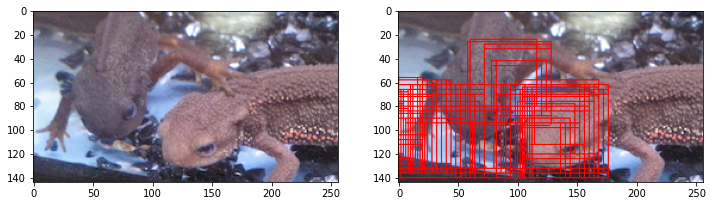

In [25]:
fig = plt.figure(figsize=(12, 60))
plt.subplot(1, 2, 1)
plt.imshow(imori_many)
plt.subplot(1, 2, 2)
plt.imshow(result)

## Q.99. 簡単な物体検出 (Step.3) Non-Maximum Suppression

In [26]:
score_threshold = 0.7
candidates = []
for x, rect in zip(test_x, rects):
    score = nn.forward(x)[0]
    if score >= threshold:
        candidates.append(rect.tolist() + [score])

candidates = sorted(candidates, key=lambda x: x[-1], reverse=True)

iou_threshold = 0.25
face_infos = []
while candidates:
    face_infos.append(candidates[0])
    rect_b0 = candidates[0][:4]
    new_candidates = []
    for candidate in candidates[1:]:
        rect_cand = candidate[:4]
        iou = get_iou(rect_b0, rect_cand)
        if iou < iou_threshold:
            new_candidates.append(candidate)
    candidates = new_candidates

In [27]:
result = imori_many.copy()
for face_info in face_infos:
    x1, y1, x2, y2 = face_info[:4]
    color = [255, 0, 0]
    result[y1, x1:x2] = color
    result[y2, x1:x2] = color
    result[y1:y2, x1] = color
    result[y1:y2, x2] = color

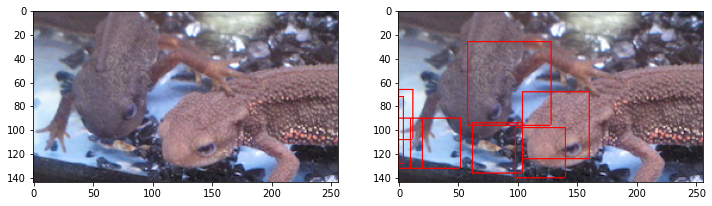

In [28]:
fig = plt.figure(figsize=(12, 60))
plt.subplot(1, 2, 1)
plt.imshow(imori_many)
plt.subplot(1, 2, 2)
plt.imshow(result)

## Q.100. 簡単な物体検出 (Step.4) 評価 Precision, Recall, F-score, mAP

In [29]:
GT = np.array(((27, 48, 95, 110), (101, 75, 171, 138)), dtype=np.int)
t = 0.5

In [30]:
G_ = 0
for gt in GT:
    scores = [get_iou(gt, face_info[:4]) for face_info in face_infos]
    if np.max(scores) >= t:
        G_ += 1

G = len(GT)

if G > 0:
    recall = G_ / G
else:
    recall = 0

print(f'Recall >> {recall} ({G_}/{G})')

Recall >> 0.5 (1/2)


In [31]:
D_ = 0
for face_info in face_infos:
    rect = face_info[:4]
    scores = [get_iou(gt, rect) for gt in GT]
    if np.max(scores) >= t:
        D_ += 1

D = len(face_infos)

if D > 0:
    precision = D_ / D
else:
    precision = 0

print(f'Precision >> {precision} ({D_}/{D})')

Precision >> 0.125 (1/8)


In [32]:
fscore = 2 * recall * precision / (recall + precision + 1e-18)
print(f'F-score >> {fscore}')

F-score >> 0.2


Question の Mean Average Precision の定義通りにしたがって以下で計算しているが、他の定義と異なっている気がする  
https://qiita.com/mdo4nt6n/items/08e11426e2fac8433fed

「judge するごとに、異なる Ground-truth の矩形を検出している」、「最終的にすべての Ground-truth の矩形を検出している」という二条件があれば、Question の定義と一致しているように思える。

In [33]:
judges = []
for face_info in face_infos:
    rect = face_info[:4]
    scores = [get_iou(gt, rect) for gt in GT]
    judges.append(1 if np.max(scores) >= t else 0)

precs = []
for i in range(len(judges)):
    precs.append(np.sum(judges[:i+1]) / (i + 1))

mAP = np.mean(precs)

print(f'mAP >> {mAP}')

mAP >> 0.15223214285714284


下の URL の定義通りにしたがって以下で計算している  
https://qiita.com/mdo4nt6n/items/08e11426e2fac8433fed

In [34]:
table = np.zeros((len(GT), len(face_infos)))
for i, gt in enumerate(GT):
    for j, face_info in enumerate(face_infos):
        table[i, j] = 1 if get_iou(face_info[:4], gt) >= t else 0

measures = []
for i in range(table.shape[1]):
    recall = np.sum(np.max(table[:, :i+1], axis=1)) / table.shape[0]
    prec = np.sum(np.max(table[:, :i+1], axis=0)) / (i + 1)
    measures.append([recall, prec])

measures.append([1, 0])
measures = sorted(measures)[::-1]

points = []
stored_recall = None
stored_prec = None
for recall, prec in measures:
    if stored_prec is None or stored_prec < prec:
        stored_prec = prec
    if stored_recall is None or stored_recall > recall:
        stored_recall = recall
        points.append([stored_recall, stored_prec])

mAP = 0
for i, (recall, prec) in enumerate(points[:-1]):
    next_recall, _ = points[i + 1]
    mAP += (recall - next_recall) * prec

print(f'mAP >> {mAP}')

mAP >> 0.16666666666666666


枠の可視化

In [35]:
result = imori_many.copy()
for x1, y1, x2, y2 in GT:
    color = [0, 255, 0]
    result[y1, x1:x2] = color
    result[y2, x1:x2] = color
    result[y1:y2, x1] = color
    result[y1:y2, x2] = color

for face_info in face_infos:
    score = np.max([get_iou(gt, face_info[:4]) for gt in GT])
    x1, y1, x2, y2 = face_info[:4]
    color = [255, 0, 0] if score >= t else [0, 0, 255]
    result[y1, x1:x2] = color
    result[y2, x1:x2] = color
    result[y1:y2, x1] = color
    result[y1:y2, x2] = color

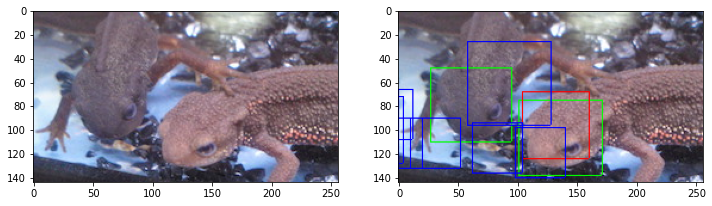

In [36]:
fig = plt.figure(figsize=(12, 60))
plt.subplot(1, 2, 1)
plt.imshow(imori_many)
plt.subplot(1, 2, 2)
plt.imshow(result)